# Experimentation Only

In [1]:
import sys
!{sys.executable} -m pip install tqdm

You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [176]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from datetime import datetime
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, tqdm_notebook
%matplotlib inline

#For Prediction
from sklearn import metrics
from sklearn import preprocessing, cross_validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.layers import Dense, Dropout, Input, LSTM, Reshape, Flatten
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop

In [238]:
# Read Datasets 
research_data = pd.read_csv('Datasets/BlockChain_Train_csv.csv')
research_data.head()

,Date,Close,USD_Exchange_Trade_Volume,Bitcoins_in_circulation,MarketCap,BlockSize,AvgBlockSize,Orphaned_Block,TransactionsPerBlock,MedianTransactCnfmTime,...,USD/JPY,USD/CHF,USD/KRW,USD/GBP,EUR/KRW,USD/CNY,Google Trends Interest,GTrends Normalized,US Federal funds rate,Breakeven Inflation Rate
0,3-Jan-09,0.0,0.0,50.0,0.0,0.0,0.0,0,1.0,0.0,...,90.73,1.06,1269.75,0.69,1774.86,6.83,0,0.0,0.08,0.15
1,5-Jan-09,0.0,0.0,50.0,0.0,0.0,0.0,0,1.0,0.0,...,92.08,1.08,1326.15,0.69,1843.95,6.82,0,0.0,0.11,0.15
2,7-Jan-09,0.0,0.0,50.0,0.0,0.0,0.0,0,1.0,0.0,...,93.79,1.12,1305.55,0.67,1763.60,6.84,0,0.0,0.11,0.47
3,9-Jan-09,0.0,0.0,750.0,0.0,0.0,0.0,0,1.0,0.0,...,91.24,1.10,1324.45,0.66,1808.74,6.83,0,0.0,0.09,0.56
4,11-Jan-09,0.0,0.0,7600.0,0.0,0.0,0.0,0,1.0,0.0,...,91.24,1.10,1324.45,0.66,1808.74,6.83,0,0.0,0.09,0.56


In [239]:
research_data.tail()

,Date,Close,USD_Exchange_Trade_Volume,Bitcoins_in_circulation,MarketCap,BlockSize,AvgBlockSize,Orphaned_Block,TransactionsPerBlock,MedianTransactCnfmTime,...,USD/JPY,USD/CHF,USD/KRW,USD/GBP,EUR/KRW,USD/CNY,Google Trends Interest,GTrends Normalized,US Federal funds rate,Breakeven Inflation Rate
1768,9-Sep-18,6286.43,291261346.9,17259100.0,1.080000e+11,181951.87,0.62,0,1158.97,7.03,...,111.01,0.97,1128.55,0.77,1305.90,6.84,54,0.54,1.92,2.10
1769,11-Sep-18,6296.32,290980772.8,17262550.0,1.090000e+11,182206.04,0.94,0,1684.90,10.53,...,111.59,0.97,1125.80,0.77,1304.82,6.88,65,0.65,1.92,2.12
1770,13-Sep-18,6450.18,321882304.6,17266500.0,1.110000e+11,182446.38,0.82,0,1582.49,8.08,...,111.86,0.97,1120.89,0.76,1309.12,6.86,65,0.65,1.92,2.10
1771,15-Sep-18,6518.66,360631436.3,17269900.0,1.130000e+11,182696.55,0.79,0,1507.65,9.03,...,112.06,0.97,1121.43,0.77,1304.73,6.87,50,0.50,1.92,2.10
1772,17-Sep-18,6400.60,181083665.0,17273325.0,1.110000e+11,182906.28,0.91,0,1778.90,9.37,...,111.98,0.96,1124.70,0.76,1314.71,6.88,58,0.58,1.92,2.10


In [240]:
TIME_STEPS = 5
BATCH_SIZE_OUT = 32
LR = 0.005
# epochs = 150
EPOCHS = 50

In [241]:
# Normalize and convert DataFrame into ndArray
# train_cols = ["Open","High","Low","Close","Volume USD","Popularity_Normalized"]
#train_cols = ["Close","TransactionsPerBlock","USD_Exchange_Trade_Volume","BlockSize_d","Total_Number_of_Transactions_d","Estimated_Transaction_Value_USD"]
train_cols = ["Close"]

df_train, df_test = train_test_split(research_data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))

# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train_out = min_max_scaler.fit_transform(x)
x_test_out = min_max_scaler.transform(df_test.loc[:,train_cols])


Train and Test size 1418 355


In [242]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [243]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE_OUT
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [244]:
def load_data(x_train, x_test, batch_size):
    x_t, y_t = build_timeseries(x_train, 0) # index of output (3)
    x_t = trim_dataset(x_t, batch_size)
    y_t = trim_dataset(y_t, batch_size)
    x_temp, y_temp = build_timeseries(x_test, 0) # index of output (3)
    x_val, x_test_t = np.split(trim_dataset(x_temp, batch_size),2)
    y_val, y_test_t = np.split(trim_dataset(y_temp, batch_size),2)
    
    return [x_t, y_t, x_val, x_test_t, y_val, y_test_t]

In [245]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [297]:
def create_generator():
#     generator=Sequential()
#     generator.add(Dense(units=128,input_dim=8))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=256))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=512))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=8, activation='tanh'))
    
#     #generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
#     generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # 6 below = x_t.shape[2]
    generator = Sequential()
    #generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform', return_sequences=False)) 
    # stateful = true breaks the model (https://github.com/keras-team/keras/issues/9385)
    generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1), dropout=0.0, recurrent_dropout=0.0, kernel_initializer='random_uniform', return_sequences=False)) 
    generator.add(Dense(8,activation='relu'))
    generator.add(Dropout(0.7))
    #generator.add(LSTM(8, return_sequences=False))
    generator.add(Dense(1,activation='sigmoid'))
    #generator.add(Reshape((5, 6)))
    optimizer = RMSprop(lr=LR, decay=3e-8)
    generator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


    return generator
g=create_generator()
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_70 (LSTM)               (16, 16)                  1152      
_________________________________________________________________
dense_364 (Dense)            (16, 8)                   136       
_________________________________________________________________
dropout_175 (Dropout)        (16, 8)                   0         
_________________________________________________________________
dense_365 (Dense)            (16, 1)                   9         
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________


In [298]:
def create_discriminator():
    optimizer = RMSprop(lr=0.0002, decay=6e-8)

    discriminator=Sequential()
    #discriminator.add(Dense(units=512, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1)))
    discriminator.add(Dense(units=512, batch_input_shape=(139, TIME_STEPS, 1)))
    
    #discriminator.add(Dense(units=512,input_dim=6))
    #discriminator.add(Dense(units=512,input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6)))
    #discriminator.add(Dense(units=512,input_shape=(TIME_STEPS, 6)))
    #discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=128))
    discriminator.add(LeakyReLU(0.2))
    
    #discriminator.add(Reshape((5, 1)))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#     discriminator = Sequential()
#     discriminator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6), dropout=0.0, recurrent_dropout=0.0, kernel_initializer='random_uniform', return_sequences=False)) 
#     discriminator.add(Dense(8,activation='relu'))
#     discriminator.add(Dropout(0.7))
#     discriminator.add(Dense(1,activation='sigmoid'))

#     discriminator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    return discriminator
d =create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_366 (Dense)            (139, 5, 512)             1024      
_________________________________________________________________
leaky_re_lu_160 (LeakyReLU)  (139, 5, 512)             0         
_________________________________________________________________
dropout_176 (Dropout)        (139, 5, 512)             0         
_________________________________________________________________
dense_367 (Dense)            (139, 5, 256)             131328    
_________________________________________________________________
leaky_re_lu_161 (LeakyReLU)  (139, 5, 256)             0         
_________________________________________________________________
dropout_177 (Dropout)        (139, 5, 256)             0         
_________________________________________________________________
dense_368 (Dense)            (139, 5, 128)             32896     
__________

In [299]:
def create_gan(discriminator, generator):
    optimizer = RMSprop(lr=0.0001, decay=3e-8)
    discriminator.trainable=False
    gan_input = Input(shape=(TIME_STEPS, 1)) # x_t.shape[2] = 6
    #Input(shape=(None, latent_dim))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        (None, 5, 1)              0         
_________________________________________________________________
sequential_125 (Sequential)  multiple                  1297      
_________________________________________________________________
sequential_126 (Sequential)  multiple                  165377    
Total params: 166,674
Trainable params: 1,297
Non-trainable params: 165,377
_________________________________________________________________


In [300]:
def create_gan2(d, g):
    optimizer = RMSprop(lr=0.0001, decay=3e-8)
    AM = Sequential()
    AM.add(g)
    AM.add(d)
    AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
        metrics=['accuracy'])
    return AM
#gan2 = create_gan2(d,g)
#gan2.summary()

In [301]:
import keras.backend as K

adversarial_loss = []
discrimator_loss = []
gen_samples = []

#K.clear_session()
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

def training(epochs=1, batch_size=128):
    global adversarial_loss
    global discrimator_loss
    global gen_samples
    
    global generator
    global discriminator
    global gan
    
    #Loading the data
    #(X_train, y_train, X_test, y_test) = load_data()
    (X_train, y_train, X_val, X_test, y_val, y_test) = load_data(x_train_out, x_test_out, BATCH_SIZE_OUT)
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    # generator = create_generator()
    # discriminator = create_discriminator()
    # gan = create_gan(discriminator, generator)
    #gan = create_gan2(discriminator, generator)
    
    for e in range(1, epochs+1 ):
        print("Epoch %d" %e)
        for i in tqdm(range(batch_size)):
            #generate  random noise as an input  to  initialize the  generator
            #noise = np.random.normal(0,1, [BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]])
            noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
            
            # Generate fake prices from noised input
            generated_prices = generator.predict(noise)
            
            # Get a random set of real prices
            prices_batch = X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            
            dim_0 = generated_prices.shape[0] - TIME_STEPS
            dim_1 = generated_prices.shape[1]
            gen_prices = np.zeros((dim_0, TIME_STEPS, 1))

            print('Shapes 1')
            print(noise.shape)
            print(prices_batch.shape)
            print(generated_prices.shape)     
            print(gen_prices.shape)
            #print(prices_batch)
            #print(generated_prices)
            
            #Construct different batches of real and fake data 
            X = np.concatenate([prices_batch, gen_prices])
            
            # Labels for generated and real data
            #y_dis = np.zeros(2*batch_size)
            #y_dis = np.zeros(shape=(2*BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]))
            y_dis = np.zeros(shape=(X.shape[0], TIME_STEPS, X_train.shape[2]))
            #y_dis[:batch_size]=0.9
            y_dis[:int((X.shape[0]/2))]=0.9
            #y_dis[0,:,batch_size]=0.9
            
            print('Shapes 2')
            print(X.shape)
            print(y_dis.shape)
            #print(y_dis)
            
            #Pre train discriminator on fake and real data before starting the gan. 
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            #noise = np.random.normal(0,1, [batch_size, 8])
            #y_gen = np.ones(batch_size)
            noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
            #y_gen = np.ones(shape=(noise.shape[0], TIME_STEPS, X_train.shape[2]))
            y_gen = np.ones(BATCH_SIZE_OUT)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            print('Shapes 3')
            print(noise.shape)
            print(y_gen.shape)
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            a_loss = gan.train_on_batch(noise, y_gen)
            
            if i == (batch_size-1):
                log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
                log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
                print(log_mesg)
                
            discrimator_loss.append(d_loss)
            adversarial_loss.append(a_loss)
            
        if e == 1 or e % 5 == 0:
            # generate synthetic dataset
            gen_samples_set = []
            for batch_idx in range(int(len(X_train) / batch_size)):
            # for batch_idx in range(int(len(X_train) / 100)):
                # noise= np.random.normal(loc=0, scale=1, size=[100, 100])
                #noise= np.random.normal(0,1, [batch_size, 8])
                noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
                generated_data = generator.predict(noise)
                gen_samples_set.append(generated_data)

            gen_samples = np.vstack(gen_samples_set)

In [302]:
#training(400,128)
training(1,128)

HBox(children=(IntProgress(value=0, max=1413), HTML(value='')))


length of time-series i/o (1413, 5, 1) (1413,)


HBox(children=(IntProgress(value=0, max=350), HTML(value='')))












  0%|          | 0/128 [00:00<?, ?it/s]


length of time-series i/o (350, 5, 1) (350,)
Epoch 1
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)













  1%|          | 1/128 [00:16<35:11, 16.63s/it]










  2%|▏         | 2/128 [00:16<24:31, 11.68s/it]

Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)













  2%|▏         | 3/128 [00:16<17:05,  8.21s/it]










  3%|▎         | 4/128 [00:16<11:56,  5.78s/it]










  4%|▍         | 5/128 [00:17<08:21,  4.07s/it]

Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)













  5%|▌         | 7/128 [00:17<05:47,  2.87s/it]

Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)













  7%|▋         | 9/128 [00:17<04:01,  2.03s/it]










  9%|▊         | 11/128 [00:17<02:48,  1.44s/it]

Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 10%|█         | 13/128 [00:17<01:58,  1.03s/it]










 12%|█▏        | 15/128 [00:17<01:23,  1.35it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)













 13%|█▎        | 17/128 [00:17<00:59,  1.87it/s]

Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 15%|█▍        | 19/128 [00:18<00:43,  2.52it/s]










 16%|█▋        | 21/128 [00:18<00:31,  3.34it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 18%|█▊        | 23/128 [00:18<00:24,  4.26it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 20%|█▉        | 25/128 [00:18<00:19,  5.33it/s]










 21%|██        | 27/128 [00:18<00:15,  6.55it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 23%|██▎       | 29/128 [00:18<00:12,  7.73it/s]












Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)


 24%|██▍       | 31/128 [00:18<00:10,  9.15it/s]










 26%|██▌       | 33/128 [00:19<00:09, 10.27it/s]

Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 27%|██▋       | 35/128 [00:19<00:07, 11.86it/s]










 29%|██▉       | 37/128 [00:19<00:06, 13.09it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 30%|███       | 39/128 [00:19<00:06, 13.59it/s]










 32%|███▏      | 41/128 [00:19<00:05, 14.69it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 34%|███▎      | 43/128 [00:19<00:05, 15.10it/s]










 35%|███▌      | 45/128 [00:19<00:05, 15.72it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 37%|███▋      | 47/128 [00:19<00:05, 15.49it/s]










 38%|███▊      | 49/128 [00:19<00:04, 16.29it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 40%|███▉      | 51/128 [00:20<00:04, 16.03it/s]










 41%|████▏     | 53/128 [00:20<00:04, 16.29it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2












 43%|████▎     | 55/128 [00:20<00:04, 16.24it/s]










 45%|████▍     | 57/128 [00:20<00:04, 16.70it/s]


(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 46%|████▌     | 59/128 [00:20<00:04, 16.60it/s]










 48%|████▊     | 61/128 [00:20<00:03, 17.02it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 49%|████▉     | 63/128 [00:20<00:03, 16.77it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)













 51%|█████     | 65/128 [00:20<00:04, 15.63it/s]










 52%|█████▏    | 67/128 [00:21<00:04, 14.72it/s]

Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 54%|█████▍    | 69/128 [00:21<00:04, 13.60it/s]










 55%|█████▌    | 71/128 [00:21<00:03, 14.52it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)












 57%|█████▋    | 73/128 [00:21<00:03, 14.73it/s]










 59%|█████▊    | 75/128 [00:21<00:03, 15.36it/s]


(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)













 60%|██████    | 77/128 [00:21<00:03, 15.60it/s]

Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 62%|██████▏   | 79/128 [00:21<00:03, 15.09it/s]










 63%|██████▎   | 81/128 [00:22<00:03, 15.00it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 65%|██████▍   | 83/128 [00:22<00:03, 14.34it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)













 66%|██████▋   | 85/128 [00:22<00:02, 14.54it/s]










 68%|██████▊   | 87/128 [00:22<00:02, 15.10it/s]

Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)













 70%|██████▉   | 89/128 [00:22<00:02, 15.87it/s]










 71%|███████   | 91/128 [00:22<00:02, 16.11it/s]












Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)


 73%|███████▎  | 93/128 [00:22<00:02, 16.62it/s]










 74%|███████▍  | 95/128 [00:22<00:02, 15.70it/s]

Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 76%|███████▌  | 97/128 [00:23<00:01, 16.18it/s]










 77%|███████▋  | 99/128 [00:23<00:01, 15.97it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)













 79%|███████▉  | 101/128 [00:23<00:01, 15.75it/s]










 80%|████████  | 103/128 [00:23<00:01, 16.67it/s]

Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 82%|████████▏ | 105/128 [00:23<00:01, 16.73it/s]










 84%|████████▎ | 107/128 [00:23<00:01, 17.23it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 85%|████████▌ | 109/128 [00:23<00:01, 16.44it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 87%|████████▋ | 111/128 [00:23<00:01, 14.42it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)













 88%|████████▊ | 113/128 [00:24<00:01, 12.31it/s]










 90%|████████▉ | 115/128 [00:24<00:01, 11.20it/s]

Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 91%|█████████▏| 117/128 [00:24<00:00, 11.92it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)













 93%|█████████▎| 119/128 [00:24<00:00, 12.48it/s]










 95%|█████████▍| 121/128 [00:24<00:00, 12.25it/s]

Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 96%|█████████▌| 123/128 [00:25<00:00, 12.64it/s]










 98%|█████████▊| 125/128 [00:25<00:00, 13.61it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)













 99%|█████████▉| 127/128 [00:25<00:00, 14.31it/s]










100%|██████████| 128/128 [00:25<00:00,  5.05it/s]

Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
Shapes 1
(16, 5, 1)
(128, 5, 1)
(16, 1)
(11, 5, 1)
Shapes 2
(139, 5, 1)
(139, 5, 1)
Shapes 3
(16, 5, 1)
(16,)
1: [D loss: 0.687822, acc: 0.497842]  [A loss: 0.694941, acc: 0.375000]


In [303]:
def get_2D_array_values(arr, idx):
    arr_map = []
    for i in range(len(arr)):
        arr_map.append(arr[i][idx])
    
    return arr_map

Text(0,0.5,'Loss')

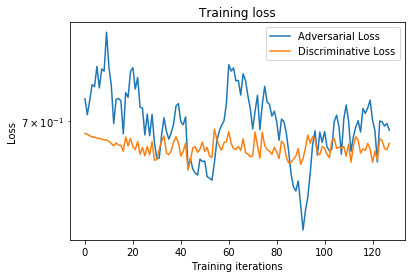

In [304]:
adversarial_loss_map = get_2D_array_values(adversarial_loss, 0)
discrimator_loss_map = get_2D_array_values(discrimator_loss, 0)

ax = pd.DataFrame(
    {
        'Adversarial Loss': adversarial_loss_map,
        'Discriminative Loss': discrimator_loss_map,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Training iterations")
ax.set_ylabel("Loss")

Text(0,0.5,'Accuracy')

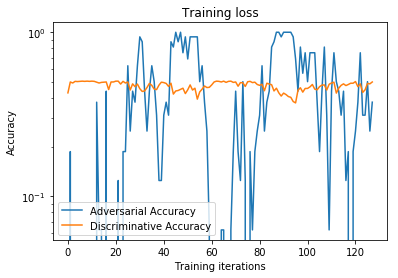

In [305]:
adversarial_acc_map = get_2D_array_values(adversarial_loss, 1)
discrimator_acc_map = get_2D_array_values(discrimator_loss, 1)

ax_acc = pd.DataFrame(
    {
        'Adversarial Accuracy': adversarial_acc_map,
        'Discriminative Accuracy': discrimator_acc_map,
    }
).plot(title='Training loss', logy=True)
ax_acc.set_xlabel("Training iterations")
ax_acc.set_ylabel("Accuracy")

In [308]:
#(X_train2, X_test2, y_train2, y_test2) = load_data_with_test2()
(X_train2, y_train2, X_val2, X_test2, y_val2, y_test2) = load_data(x_train_out, x_test_out, BATCH_SIZE_OUT)

print(x_train_out.shape)
print(x_test_out.shape)

print(X_train2.shape)
print(X_test2.shape)
print(X_val2.shape)

prediction_gan = generator.predict(X_test2)

# print("The Explained Variance: %.2f" % prediction_gan.score(X_test2, y_test2))  
print("The Explained Variance: %.2f" % metrics.explained_variance_score(y_test2, prediction_gan))  
print("The Mean Absolute Error: %.2f" % metrics.mean_absolute_error(y_test2, prediction_gan))  
#print("The Median Absolute Error: %.2f" % metrics.median_absolute_error(y_test2, prediction_gan)) 
print("The Mean Squared Error: %.2f" % metrics.mean_squared_error(y_test2, prediction_gan)) 
print("The Root Mean Squared Error: %.2f" % (np.sqrt(metrics.mean_squared_error(y_test2, prediction_gan))))

generator.predict(X_train)[0]

HBox(children=(IntProgress(value=0, max=1413), HTML(value='')))


length of time-series i/o (1413, 5, 1) (1413,)


HBox(children=(IntProgress(value=0, max=350), HTML(value='')))


length of time-series i/o (350, 5, 1) (350,)
(1418, 1)
(355, 1)
(1408, 5, 1)
(168, 5, 1)
(168, 5, 1)


ValueError: Cannot feed value of shape (32, 5, 1) for Tensor 'lstm_71_input:0', which has shape '(16, 5, 1)'